In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# ---- 1) Model parameters ----
C       = 1.0    # μF/cm²
gbar_K  = 36.0   # mS/cm²
gbar_Na = 120.0  # mS/cm²
g_leak  = 0.3    # mS/cm²
E_K     = -72.0  # mV
E_Na    = 55.0   # mV
E_leak  = -49.0  # mV

In [29]:


# ---- 2) Rate constants α and β ----
def alpha_n(V):
    return 0.01*(V + 50.0) / (1.0 - np.exp(-(V + 50.0)/10.0))

def beta_n(V):
    return 0.125 * np.exp(-(V + 60.0)/80.0)

def alpha_m(V):
    return 0.1*(V + 35.0) / (1.0 - np.exp(-(V + 35.0)/10.0))

def beta_m(V):
    return 4.0 * np.exp(-(V + 60.0)/18.0)

def alpha_h(V):
    return 0.07 * np.exp(-(V + 60.0)/20.0)

def beta_h(V):
    return 1.0 / (1.0 + np.exp(-(V + 30.0)/10.0))

# ---- 3) Steady-states and time-constants from α+β ----
def n_inf(V):
    an = alpha_n(V); bn = beta_n(V)
    return an / (an + bn)

def tau_n(V):
    an = alpha_n(V); bn = beta_n(V)
    return 1.0 / (an + bn)

def m_inf(V):
    am = alpha_m(V); bm = beta_m(V)
    return am / (am + bm)

def tau_m(V):
    am = alpha_m(V); bm = beta_m(V)
    return 1.0 / (am + bm)

def h_inf(V):
    ah = alpha_h(V); bh = beta_h(V)
    return ah / (ah + bh)

def tau_h(V):
    ah = alpha_h(V); bh = beta_h(V)
    return 1.0 / (ah + bh)

# ---- 4) Stimulus current I_app(t) ----
def I_app(t):
    if   t < 20.0:        return 0.0
    elif t < 21.0:        return 2.0
    elif t < 60.0:        return 0.0
    elif t < 61.0:        return 10.0
    else:                 return 0.0

# ---- 5) HH ODE system (only 4 states) ----
def hh_rhs(y, t):
    V, n, m, h = y
    I = I_app(t)

    dn = (n_inf(V) - n) / tau_n(V)
    dm = (m_inf(V) - m) / tau_m(V)
    dh = (h_inf(V) - h) / tau_h(V)

    gK  = gbar_K  * n**4
    gNa = gbar_Na * m**3 * h
    Ileak = g_leak * (V - E_leak)

    IK   = gK  * (V - E_K)
    INa  = gNa * (V - E_Na)
    dV   = (I - IK - INa - Ileak) / C

    return [dV, dn, dm, dh]

# ---- 6) Integrate ----
t   = np.linspace(0, 100.0, 5001)
y0 = [-59.8977, 0.3192, 0.0530, 0.5925]
sol = odeint(hh_rhs, y0, t)
V, n, m, h = sol.T

# ---- 7) Compute currents post hoc ----
gK  = gbar_K * n**4
gNa = gbar_Na * m**3 * h
IK   = -gK  * (V - E_K)
INa  = -gNa * (V - E_Na)


# 1) Find the exact times of the Na+ and K+ peaks:
t_na_peak = t[np.argmin(INa)]   # Na+ is negative inward current, so minimum
t_k_peak  = t[np.argmax(IK)]    # K+ is outward current, so maximum
print(f"Na peak at {t_na_peak:.3f} ms,  K peak at {t_k_peak:.3f} ms,  lag = {t_k_peak - t_na_peak:.3f} ms")





Na peak at 65.640 ms,  K peak at 74.460 ms,  lag = 8.820 ms


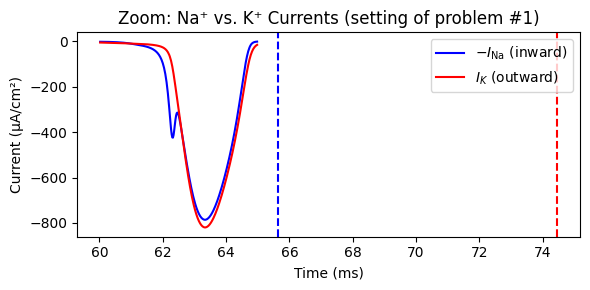

In [31]:

# zoomed-in view: narrow window around the second pulse
mask = (t > 60) & (t < 65)

plt.figure(figsize=(6,3))
plt.plot(t[mask], -INa[mask], 'b-', label=r'$-I_{\mathrm{Na}}$ (inward)')
plt.plot(t[mask],  IK[mask], 'r-', label=r'$I_{K}$ (outward)')
plt.axvline(t_na_peak, color='b', linestyle='--')
plt.axvline(t_k_peak,  color='r', linestyle='--')
plt.xlabel('Time (ms)')
plt.ylabel('Current (µA/cm²)')
plt.legend(loc='upper right')
plt.title('Zoom: Na⁺ vs. K⁺ Currents (setting of problem #1)')
plt.tight_layout()
plt.show()
